# Google Stock Price Prediction


I. Explore and Prepare Data


In [3]:
import pandas as pd

data = pd.read_csv('GOOG.csv')
data['Date'] = pd.to_datetime(data['Date'])

print(data.head())

        Date      Open      High       Low     Close  Adj Close     Volume
0 2004-08-19  2.490664  2.591785  2.390042  2.499133   2.499133  897427216
1 2004-08-20  2.515820  2.716817  2.503118  2.697639   2.697639  458857488
2 2004-08-23  2.758411  2.826406  2.716070  2.724787   2.724787  366857939
3 2004-08-24  2.770615  2.779581  2.579581  2.611960   2.611960  306396159
4 2004-08-25  2.614201  2.689918  2.587302  2.640104   2.640104  184645512


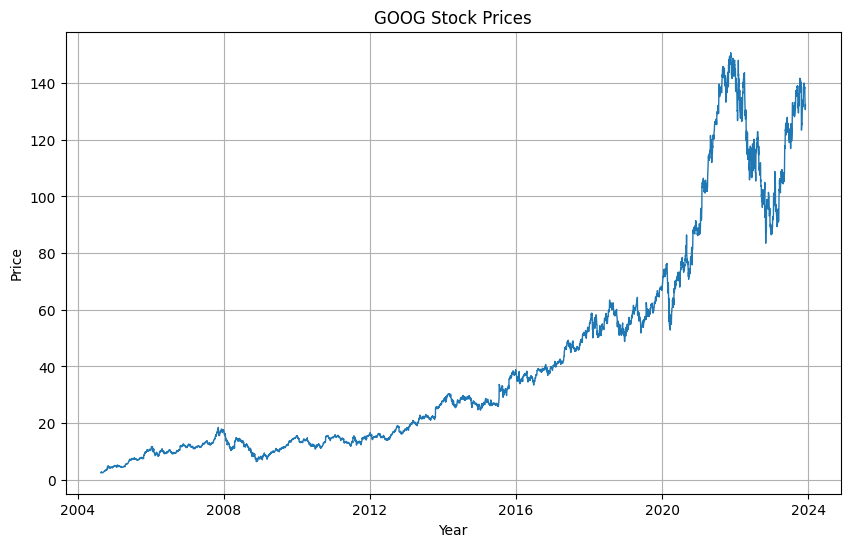

In [4]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Close'], linewidth=1)

# Titles and labels
plt.title('GOOG Stock Prices')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid(True)
plt.show()

The data is not stationary. We can see there is a positive trend over time with fluctuations, which indicates increasing variance. We will need to apply the Box-Cox transformation to get a constant variance.

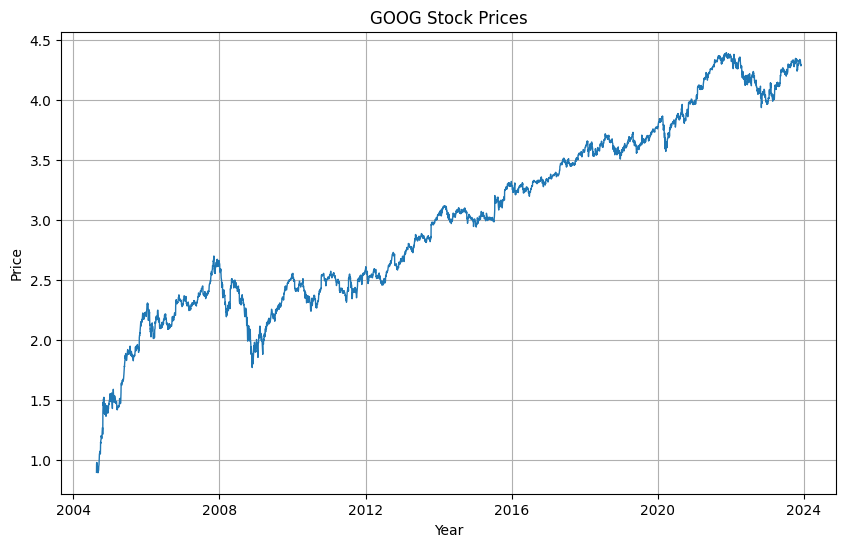

In [5]:
from scipy.stats import boxcox

data['Close BoxCox'], lam = boxcox(data['Close'])

# Plot
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Close BoxCox'], linewidth=1)

# Titles and labels
plt.title('GOOG Stock Prices')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid(True)
plt.show()

The data now appears to be stationary.

II. Feature Engineering

In [6]:
# Date
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

data['Daily Returns'] = (data['Close'] - data['Open']) / data['Open']
data['High-Low Range'] = data['High'] - data['Low']
data['Prev Close'] = data['Close'].shift(1)
data['Prev Open'] = data['Open'].shift(1)
data['Prev High'] = data['High'].shift(1)
data['Prev Low'] = data['Low'].shift(1)
data['Prev Volume'] = data['Volume'].shift(1)
data['50-Day Moving Average'] = data['Close'].rolling(window=50).mean()
data['200-Day Moving Average'] = data['Close'].rolling(window=200).mean()

features = ['Year', 'Month', 'Day', 'Prev Close', 'Prev Open', 'Prev High', 'Prev Low', 'Prev Volume', '50-Day Moving Average', '200-Day Moving Average']
data[features] = data[features].fillna(0)


III. Model

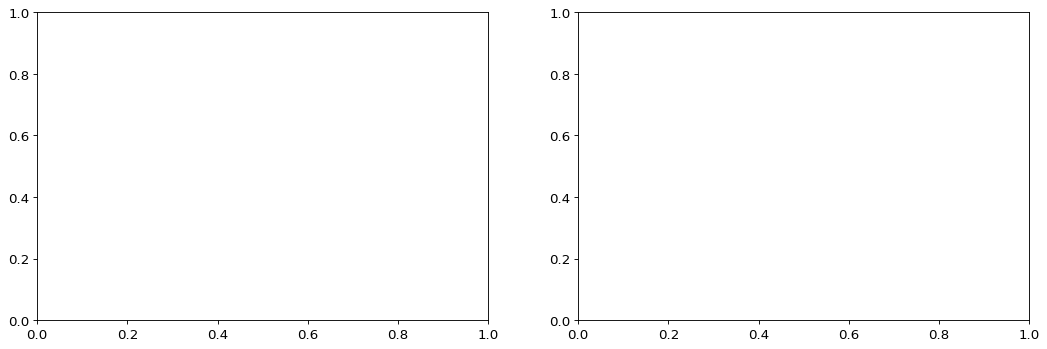

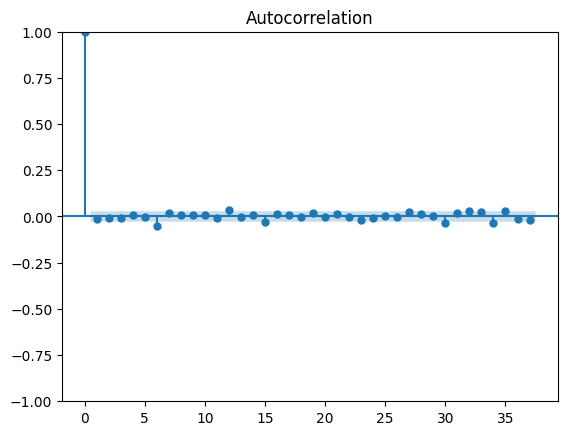

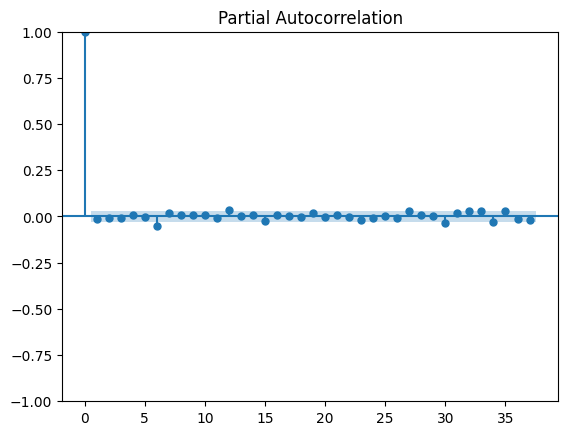

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

data['Close Diff'] = data['Close BoxCox'].diff()
data.dropna(inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), dpi=80)
plot_acf(data['Close Diff'])
plot_pacf(data['Close Diff'], method='ywm')
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()

The last lag that is statistically significant for both plots is around the 6th, so take p and q to be 6.

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.special import inv_boxcox

# Split train and test set
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

# Build ARIMA model
#model = ARIMA(train['Close BoxCox'], order=(2, 2, 6)).fit()
seasonal_order = (1, 1, 1, 18)
model = SARIMAX(train['Close BoxCox'], order=(6, 2, 6), seasonal_order=seasonal_order).fit()
boxcox_forecasts = model.forecast(len(test))

# Inverse Box-Cox
forecasts = inv_boxcox(boxcox_forecasts, lam)

c:\Users\vecto\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\vecto\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\vecto\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\vecto\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\st

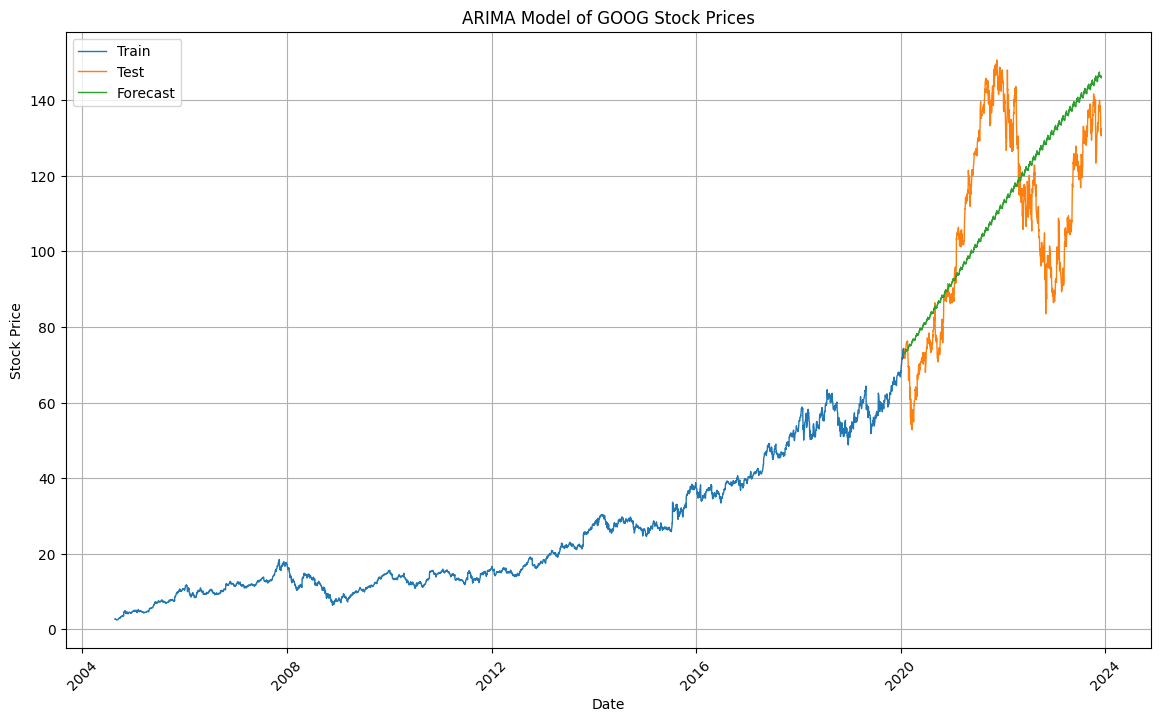

In [9]:
import matplotlib.dates as mdates

# Plot
plt.figure(figsize=(14,8))
plt.plot(train['Date'], train['Close'], label='Train', linewidth=1)
plt.plot(test['Date'], test['Close'], label='Test', linewidth=1)
plt.plot(test['Date'], forecasts, label='Forecast', linewidth=1)

# Title and labels
plt.title('ARIMA Model of GOOG Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')

# Formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()
